In [3]:

!mkdir -p Heart_Disease_Project/data

!unzip -o heart+disease.zip -d Heart_Disease_Project/data

!ls Heart_Disease_Project/data


Archive:  heart+disease.zip
  inflating: Heart_Disease_Project/data/Index  
  inflating: Heart_Disease_Project/data/WARNING  
  inflating: Heart_Disease_Project/data/ask-detrano  
  inflating: Heart_Disease_Project/data/bak  
  inflating: Heart_Disease_Project/data/cleve.mod  
  inflating: Heart_Disease_Project/data/cleveland.data  
   creating: Heart_Disease_Project/data/costs/
  inflating: Heart_Disease_Project/data/costs/Index  
  inflating: Heart_Disease_Project/data/costs/heart-disease.README  
  inflating: Heart_Disease_Project/data/costs/heart-disease.cost  
  inflating: Heart_Disease_Project/data/costs/heart-disease.delay  
  inflating: Heart_Disease_Project/data/costs/heart-disease.expense  
  inflating: Heart_Disease_Project/data/costs/heart-disease.group  
  inflating: Heart_Disease_Project/data/heart-disease.names  
  inflating: Heart_Disease_Project/data/hungarian.data  
  inflating: Heart_Disease_Project/data/long-beach-va.data  
  inflating: Heart_Disease_Project/data/ne

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_DIR = Path("Heart_Disease_Project/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

processed_files = [
    "processed.cleveland.data",
    "processed.hungarian.data",
    "processed.switzerland.data",
    "processed.va.data",
]


print("Looking for files:")
for f in processed_files:
    print(" -", f, "->", (DATA_DIR / f).exists())


cols = [
    "age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang",
    "oldpeak","slope","ca","thal","num"
]


frames = []
for fname in processed_files:
    path = DATA_DIR / fname
    if not path.exists():
        print(f"WARNING: {fname} not found, skipping.")
        continue
    df_i = pd.read_csv(path, names=cols, na_values=["?" ])
    frames.append(df_i)

assert len(frames) > 0, "None of the processed .data files were found. Check your unzip path."
df = pd.concat(frames, ignore_index=True)
print("Combined shape (before cleaning):", df.shape)


for c in cols:
    if c != "sex" and c != "cp" and c != "fbs" and c != "restecg" and c != "exang" and c != "slope" and c != "ca" and c != "thal":

        df[c] = pd.to_numeric(df[c], errors="coerce")
    else:

        df[c] = pd.to_numeric(df[c], errors="coerce")


df["target"] = (df["num"] > 0).astype("int8")
df.drop(columns=["num"], inplace=True)


na_counts = df.isna().sum().sort_values(ascending=False)
print("\nMissing values per column:")
print(na_counts[na_counts > 0])

save_path = DATA_DIR / "heart_disease.csv"
df.to_csv(save_path, index=False)
print(f"\nSaved merged CSV -> {save_path}")


display(df.head())
print("Class balance (target):\n", df["target"].value_counts(dropna=False))
print("\nDataset info:")
print(df.info())


Looking for files:
 - processed.cleveland.data -> True
 - processed.hungarian.data -> True
 - processed.switzerland.data -> True
 - processed.va.data -> True
Combined shape (before cleaning): (920, 14)

Missing values per column:
ca          611
thal        486
slope       309
fbs          90
oldpeak      62
trestbps     59
thalach      55
exang        55
chol         30
restecg       2
dtype: int64

Saved merged CSV -> Heart_Disease_Project/data/heart_disease.csv


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Class balance (target):
 target
1    509
0    411
Name: count, dtype: int64

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    float64
 1   sex       920 non-null    float64
 2   cp        920 non-null    float64
 3   trestbps  861 non-null    float64
 4   chol      890 non-null    float64
 5   fbs       830 non-null    float64
 6   restecg   918 non-null    float64
 7   thalach   865 non-null    float64
 8   exang     865 non-null    float64
 9   oldpeak   858 non-null    float64
 10  slope     611 non-null    float64
 11  ca        309 non-null    float64
 12  thal      434 non-null    float64
 13  target    920 non-null    int8   
dtypes: float64(13), int8(1)
memory usage: 94.5 KB
None


In [9]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

plt.rcParams["figure.figsize"] = (8,6)
DATA_DIR = Path("Heart_Disease_Project/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)


In [12]:
csvs = list(DATA_DIR.glob("*.csv"))
print("CSV files found:", [p.name for p in csvs])

assert len(csvs) > 0, "No CSV found. Create heart_disease.csv first (use the merge-all cell I gave earlier)."
df = pd.read_csv(csvs[0])
df = df.replace("?", np.nan)

print("Shape:", df.shape)
display(df.head())
display(df.isna().sum().sort_values(ascending=False).head(10))


CSV files found: ['heart_disease.csv']
Shape: (920, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


,0
ca,611
thal,486
slope,309
fbs,90
oldpeak,62
trestbps,59
thalach,55
exang,55
chol,30
restecg,2


In [13]:
if "target" in df.columns:
    y = df["target"]
    X = df.drop(columns=["target"])
elif "num" in df.columns:
    y = (df["num"] > 0).astype(int)
    X = df.drop(columns=["num"])
    y.name = "target"
else:
    y = df.iloc[:, -1]
    X = df.iloc[:, :-1]
    y.name = "target"

print("Target name:", y.name)
print("Class balance:\n", y.value_counts(normalize=True).round(3))
display(X.head())


Target name: target
Class balance:
 target
1    0.553
0    0.447
Name: proportion, dtype: float64


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [14]:
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

for col in ["sex","cp","fbs","restecg","exang","slope","ca","thal"]:
    if col in X.columns:
        X[col] = X[col].astype("category")
        if col not in cat_cols: cat_cols.append(col)
        if col in num_cols: num_cols.remove(col)

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
Categorical columns: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


In [15]:
use_minmax = True

num_imputer = SimpleImputer(strategy="median")
num_scaler = MinMaxScaler() if use_minmax else StandardScaler()
num_pipe = Pipeline([
    ("imputer", num_imputer),
    ("scaler", num_scaler)
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])
preprocess


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['age', 'trestbps', 'chol', 'thalach',
                                  'oldpeak']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['sex', 'cp', 'fbs', 'restecg', 'exang',
                                  'slope', 'ca', 'thal'])])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(736, 13) (184, 13) (736,) (184,)


In [17]:

X_train_clean = preprocess.fit_transform(X_train)
X_test_clean  = preprocess.transform(X_test)


oh = preprocess.named_transformers_.get("cat", None)
oh = oh.named_steps["onehot"] if (oh and cat_cols) else None
oh_names = list(oh.get_feature_names_out(cat_cols)) if oh else []
feature_names = num_cols + oh_names

X_train_clean_df = pd.DataFrame(X_train_clean, columns=feature_names, index=X_train.index)
X_test_clean_df  = pd.DataFrame(X_test_clean,  columns=feature_names, index=X_test.index)

train_clean = pd.concat([X_train_clean_df, y_train], axis=1)
test_clean  = pd.concat([X_test_clean_df, y_test], axis=1)

train_path = DATA_DIR / "heart_disease_clean_train.csv"
test_path  = DATA_DIR / "heart_disease_clean_test.csv"
train_clean.to_csv(train_path, index=False)
test_clean.to_csv(test_path, index=False)

print("Saved:")
print("-", train_path)
print("-", test_path)
display(train_clean.head())


Saved:
- Heart_Disease_Project/data/heart_disease_clean_train.csv
- Heart_Disease_Project/data/heart_disease_clean_test.csv


,age,trestbps,chol,thalach,oldpeak,sex_0.0,sex_1.0,cp_1.0,cp_2.0,cp_3.0,...,slope_2.0,slope_3.0,ca_0.0,ca_1.0,ca_2.0,ca_3.0,thal_3.0,thal_6.0,thal_7.0,target
640,0.510204,0.666667,0.000000,0.424460,0.295455,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
743,0.938776,0.416667,0.000000,0.553957,0.352273,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
890,0.510204,0.366667,0.402985,0.424460,0.522727,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
270,0.673469,0.500000,0.343284,0.539568,0.511364,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
654,0.571429,0.625000,0.000000,0.258993,0.295455,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1


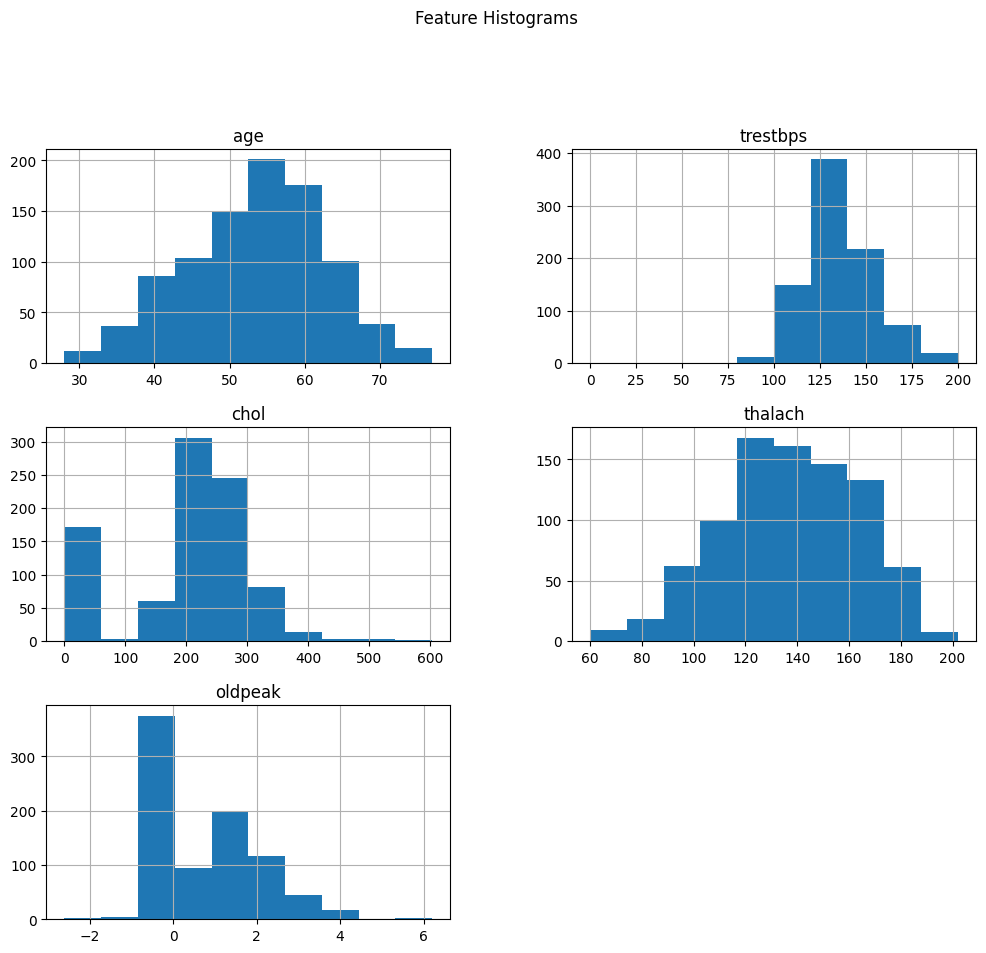

In [18]:
_ = X[num_cols].hist(figsize=(12,10))
plt.suptitle("Feature Histograms", y=1.02)
plt.show()


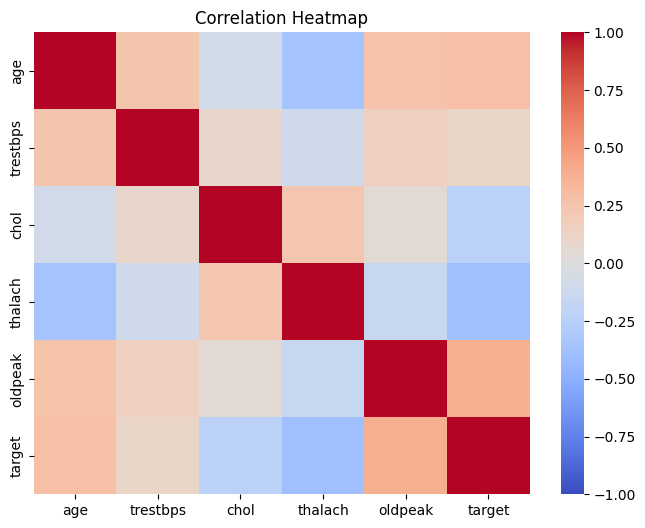

In [19]:
corr = pd.concat([X[num_cols], y], axis=1).corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()


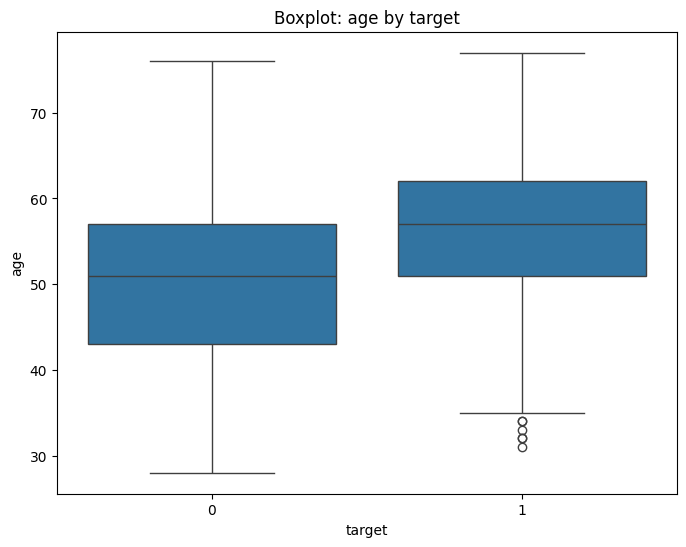

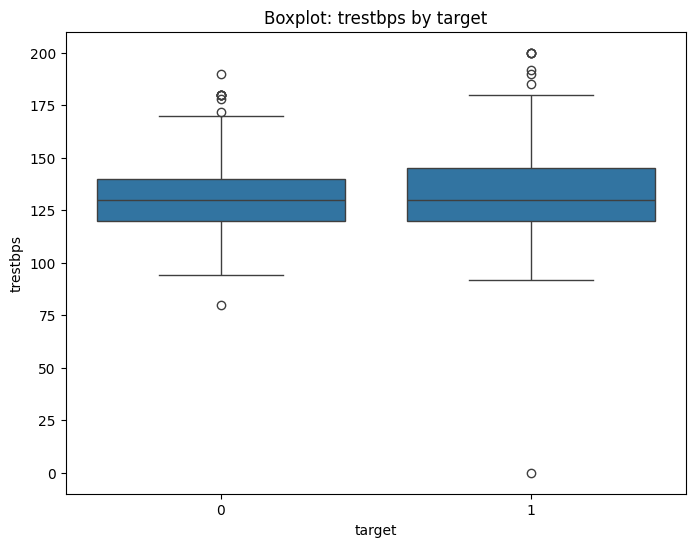

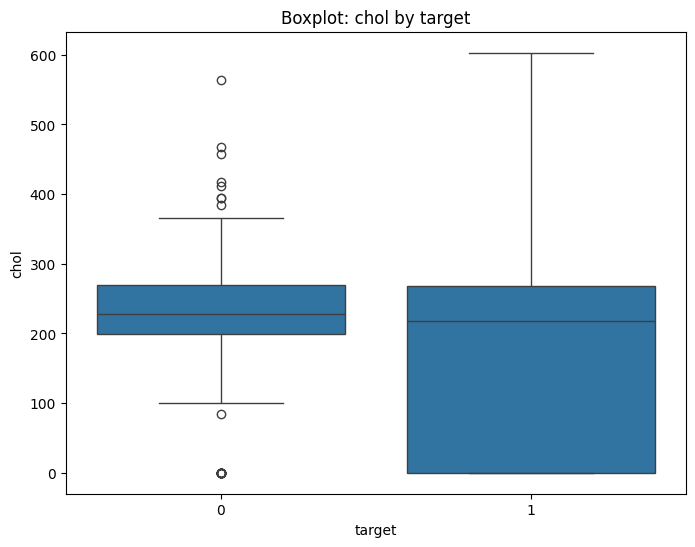

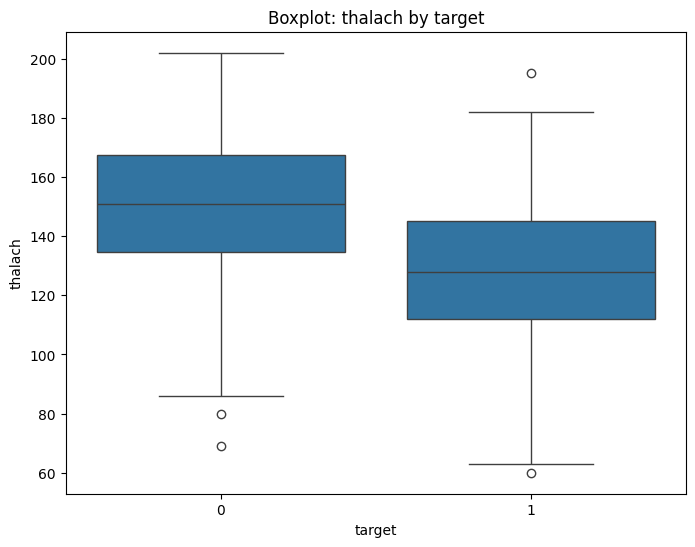

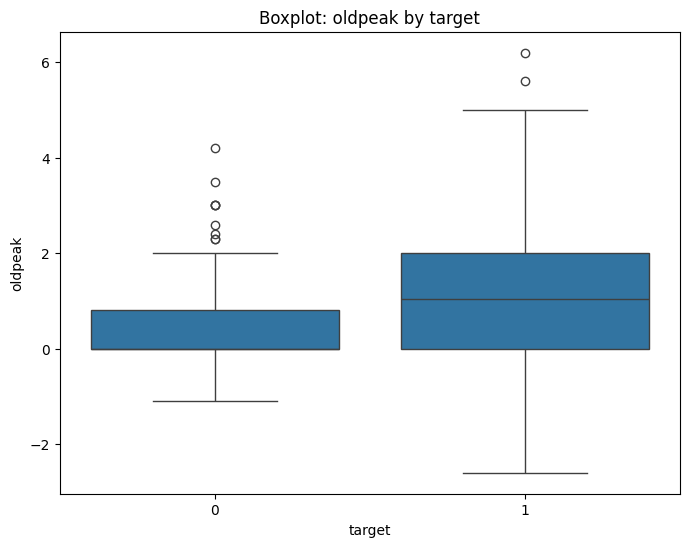

In [20]:
for col in num_cols:
    sns.boxplot(x=y, y=X[col])
    plt.title(f"Boxplot: {col} by target")
    plt.show()


In [21]:
print("Missing values before preprocessing:\n", X.isna().sum())
print("Any missing after transform?", np.isnan(X_train_clean).sum())


Missing values before preprocessing:
 age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalach      55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64
Any missing after transform? 0
